# Code for question 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45

# Q2.a)




\begin{align*}
    \dot{x}_1(t) &= -\beta x_1(t) x_2(t) \\
    \dot{x}_2(t) &= \beta x_1(t) x_2(t) - \gamma x_2(t) \\
    \dot{x}_3(t) &= \gamma x_2(t) \\
\end{align*}


In [2]:
beta_ = 0.2
gamma_ = 0.05
x_0 = np.array([0.995, 0.005, 0])

F = lambda x : np.array([
    - beta_ * x[0] * x[1],
    beta_ * x[0] * x[1] - gamma_ * x[1],
    gamma_ * x[1]
])

def SIR_model(t, x):
    return [- beta_ * x[0] * x[1], beta_ * x[0] * x[1] - gamma_ * x[1], gamma_ * x[1]]

T_max = 201
X = np.zeros((T_max, 3))
B = np.zeros((T_max, 3))
X[0] = x_0


solver = RK45(SIR_model, 1, x_0, T_max, max_step=1)


for t in range(1, T_max):
    solver.step()
    X[t] = solver.y


for i in range(T_max - 1):
    B[i] = (X[i + 1] - X[i])

B[200] = X[200] - X[199]


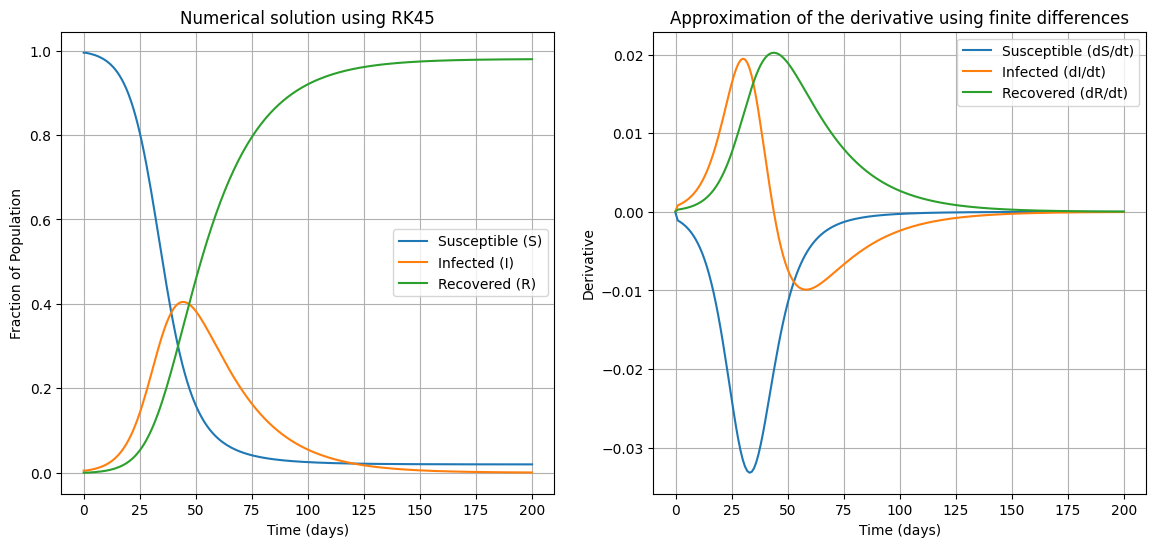

In [3]:
time_points = np.arange(T_max)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot X
axs[0].plot(np.arange(T_max), X[:, 0], label="Susceptible (S)")
axs[0].plot(np.arange(T_max), X[:, 1], label="Infected (I)")
axs[0].plot(np.arange(T_max), X[:, 2], label="Recovered (R)")
axs[0].set_title("Numerical solution using RK45")
axs[0].set_xlabel("Time (days)")
axs[0].set_ylabel("Fraction of Population")
axs[0].legend()
axs[0].grid(True)

# Plot B
axs[1].plot(time_points, B[:, 0], label="Susceptible (dS/dt)")
axs[1].plot(time_points, B[:, 1], label="Infected (dI/dt)")
axs[1].plot(time_points, B[:, 2], label="Recovered (dR/dt)")
axs[1].set_title("Approximation of the derivative using finite differences")
axs[1].set_xlabel("Time (days)")
axs[1].set_ylabel("Derivative")
axs[1].legend()
axs[1].grid(True)

### Save X and B into a text file

In [4]:
np.savetxt("save_X.txt", X)
np.savetxt("save_B.txt", B)

# Q2.b)

Algo:

1/ $z_k = \alpha^k - \frac{2}{L}\Theta^T (\Theta \alpha_k - b)\\$
2/ $\alpha^{k+1} = \min_{\alpha} || z^k - \alpha ||_2^2 + |\alpha| \\$

$\alpha^{k+1}_i = z_i - \frac{\lambda}{2L}$ if $\alpha^k > 0\\$
$\alpha^{k+1}_i = z_i + \frac{\lambda}{2L}$ if $\alpha^k < 0\\$

In [72]:
reg = lambda x, c : x + c if x < -c else x - c if x > c else 0.0
reg_vect = np.vectorize(reg)


cost = lambda x_1, x_2: np.linalg.norm(x_1 - x_2)


def proximal_gd(Theta, b, L = 1, lambda_ = 0.001, eps = 10**-5) -> np.array:
    """
        Theta = m x p matrix
        b = m x 1 matrix 
    """
    
    Theta_T = np.transpose(Theta)
    alpha = np.zeros(len(Theta[0]))
    c = lambda_/L

    cost_func = []


    # Perform the first gradient step
    z = alpha - (1/L) * (Theta_T @ (Theta @ alpha - b))
    alpha_prv = alpha
    alpha = reg_vect(z, c) # Regularize z

    i_iter = 1
    COST = L * cost(alpha, alpha_prv)
    cost_func.append(COST)

    while (COST > eps):
        z = alpha - (1/L) * (Theta_T @ (Theta @ alpha - b)) # Gradient step
        alpha_prv = alpha
        alpha = reg_vect(z, c) # Regularize z into alpha
        
        i_iter += 1
        COST = L * cost(alpha, alpha_prv)
        cost_func.append(COST)

    return alpha, (i_iter, cost_func)

# Q2.c)

In [145]:
B_text = np.loadtxt("save_B.txt")
X_text = np.loadtxt("save_X.txt")

l1 = lambda x1, x2, x3: x1
l2 = lambda x1, x2, x3: x2
l3 = lambda x1, x2, x3: x3
l4 = lambda x1, x2, x3: x1 * x2
l5 = lambda x1, x2, x3: x2 * x3

thetas = [l1, l2, l3, l4, l5]

p = 5
m = len(B_text)
n = 3

THETA = np.zeros((m, p))


for i in range(m):
    for j in range(p):
        THETA[i][j] = thetas[j](X_text[i][0], X_text[i][1], X_text[i][2])

In [160]:
L = np.linalg.norm(THETA, ord=2) ** 2
lambda_ = 0.1

a1, (i1, cost1) = proximal_gd(THETA, B_text[:, 0], lambda_= lambda_, L = L, eps=10**-5)
a2, (i2, cost2)= proximal_gd(THETA, B_text[:, 1],lambda_= lambda_,  L = L)
a3, (i3, cost3) = proximal_gd(THETA, B_text[:, 2],lambda_= lambda_,  L = L)

theta_func = lambda x : np.array([l1(x[0], x[1], x[2]), l2(x[0], x[1], x[2]), l3(x[0], x[1], x[2]), l4(x[0], x[1], x[2]), l5(x[0], x[1], x[2])])
T = np.arange(0, 201, 1)


# b_0 = np.array([0, 0, 0]) 
b_0 = np.array([0.995, 0.005, 0])
X_appx = np.zeros((201, 3))

X_appx[0] = b_0

for t in range(1, 201):
    X_appx[t] = X_appx[t - 1] + np.array([theta_func(X_appx[t - 1]) @ a1, theta_func(X_appx[t - 1]) @ a2, theta_func(X_appx[t - 1]) @ a3 ])
    # B_appx[t] = B_appx[t - 1] + B_text[t]


print(a1)
print(a2)
print(a3)




[-0.01063541 -0.01950995  0.          0.          0.        ]
[ 0.00563766  0.         -0.00151537  0.          0.        ]
[0.00015755 0.02887678 0.00076032 0.         0.        ]


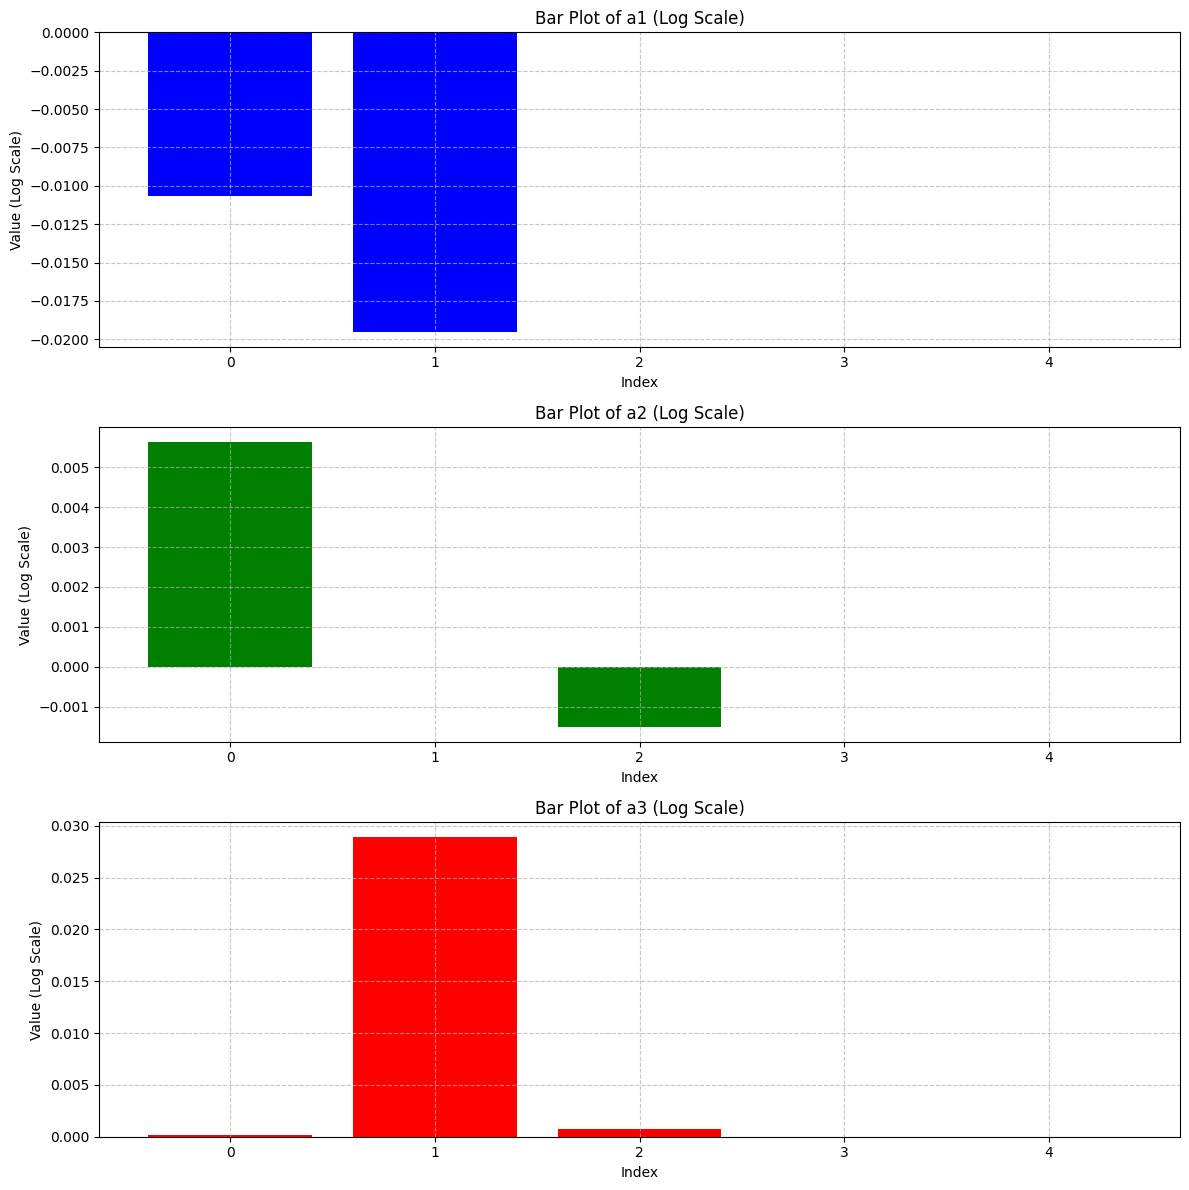

In [161]:
import matplotlib.pyplot as plt

# Create a figure and subplots with 3 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot a1 in log scale for y-axis
axes[0].bar(range(len(a1)), a1, color='blue')
axes[0].set_title('Bar Plot of a1 (Log Scale)')
axes[0].grid(True, linestyle='--', alpha=0.7)
# axes[0].set_yscale('log')

# Plot a2 in log scale for y-axis
axes[1].bar(range(len(a2)), a2, color='green')
axes[1].set_title('Bar Plot of a2 (Log Scale)')
axes[1].grid(True, linestyle='--', alpha=0.7)
# axes[1].set_yscale('log')

# Plot a3 in log scale for y-axis
axes[2].bar(range(len(a3)), a3, color='red')
axes[2].set_title('Bar Plot of a3 (Log Scale)')
axes[2].grid(True, linestyle='--', alpha=0.7)
# axes[2].set_yscale('log')

# Set common labels
for ax in axes:
    ax.set_xlabel('Index')
    ax.set_ylabel('Value (Log Scale)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


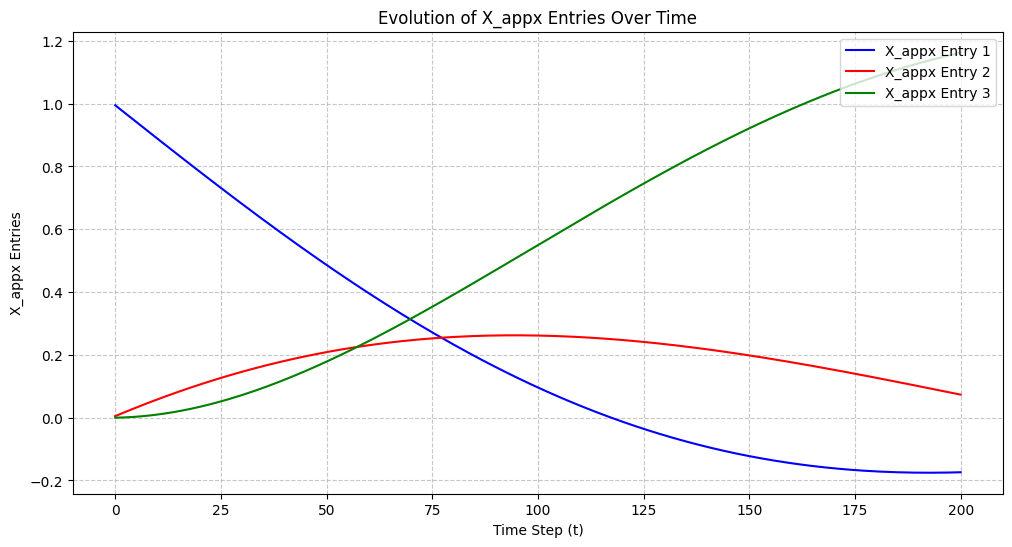

In [162]:
plt.figure(figsize=(12, 6))

# Plot each of the three entries in B_appx over time T
plt.plot(T, X_appx[:, 0], label='X_appx Entry 1', color='blue')
plt.plot(T, X_appx[:, 1], label='X_appx Entry 2', color='red')
plt.plot(T, X_appx[:, 2], label='X_appx Entry 3', color='green')

# Adding plot labels and legend
plt.title('Evolution of X_appx Entries Over Time')
plt.xlabel('Time Step (t)')
plt.ylabel('X_appx Entries')
plt.legend(loc='upper right')

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [163]:
c1 = np.linalg.norm(X_text[:, 0] - X_appx[:, 0]) ** 2
c2 = np.linalg.norm(X_text[:, 1] - X_appx[:, 1]) ** 2
c3 = np.linalg.norm(X_text[:, 2] - X_appx[:, 2]) ** 2

print(c1)
print(c2)
print(c3)

6.051293399651645
4.888468494012304
12.013489738832716


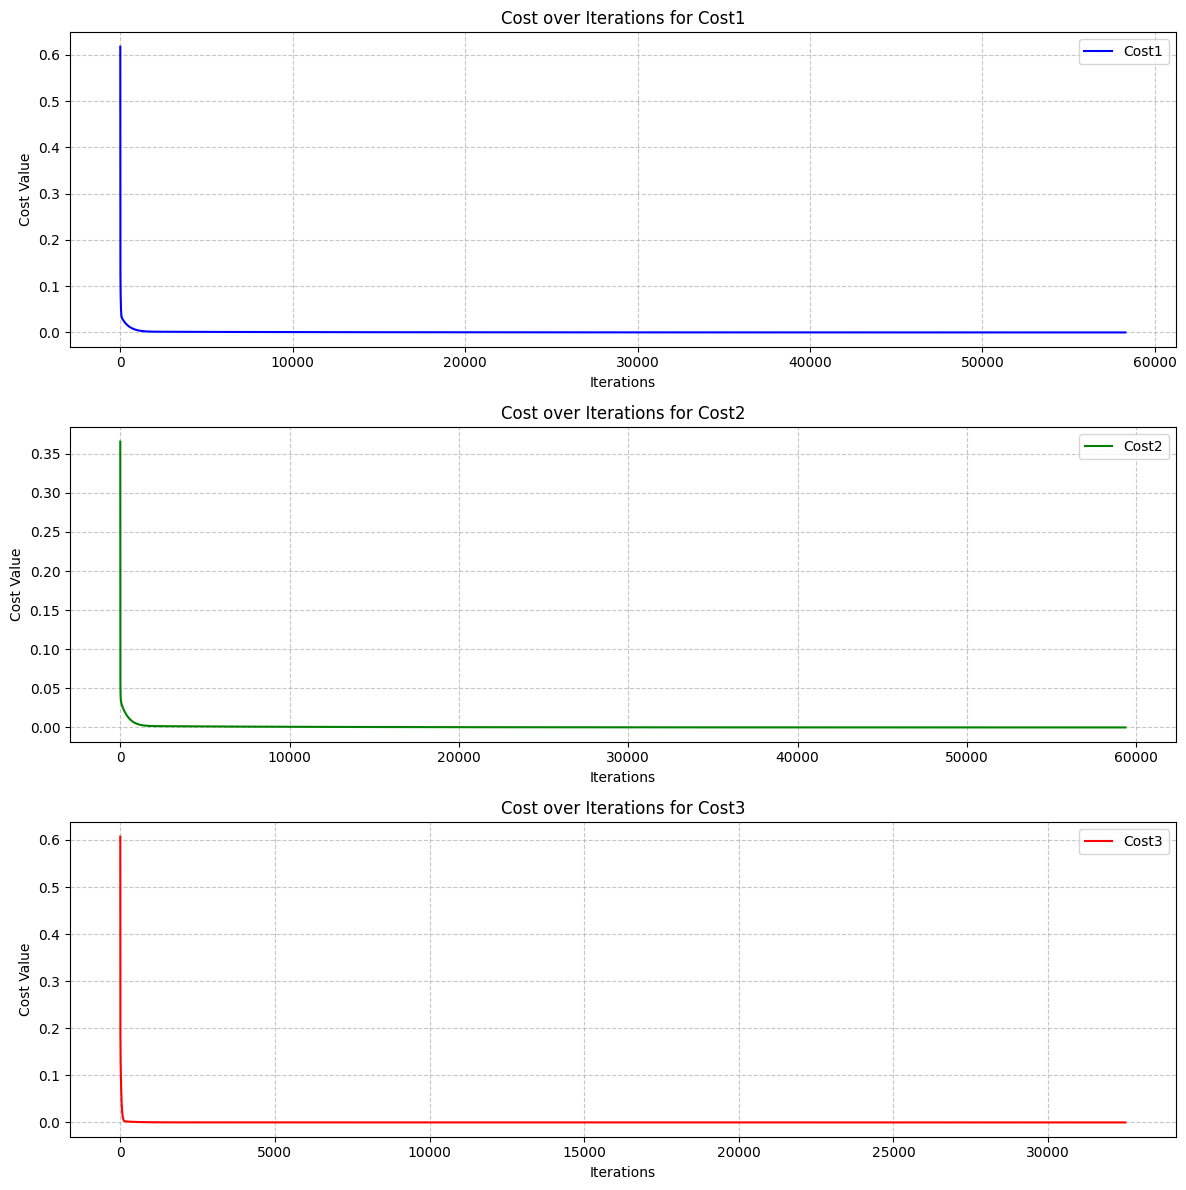

In [150]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot cost1
axes[0].plot(cost1, color='blue', label='Cost1')
axes[0].set_title('Cost over Iterations for Cost1')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Plot cost2
axes[1].plot(cost2, color='green', label='Cost2')
axes[1].set_title('Cost over Iterations for Cost2')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

# Plot cost3
axes[2].plot(cost3, color='red', label='Cost3')
axes[2].set_title('Cost over Iterations for Cost3')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend()

# Set common labels for the subplots (if needed)
for ax in axes:
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

